## Labelling Publications with New Topic Model (Lauren's New Buckets)


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load SPECTER model + tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/specter")
model = AutoModel.from_pretrained("allenai/specter")
print("Model and tokenizer loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model and tokenizer loaded.


In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

model_name = 'allenai/specter2_base'

try:
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    print(f"Successfully loaded model: {model_name}")

     # Function to get embeddings using the loaded model
    def get_embeddings_hf(texts, tokenizer, model):
        # Tokenize the texts
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)

        # Get model outputs
        with torch.no_grad():
            outputs = model(**inputs)

        # Typically, for sentence embeddings, you'd use the mean of the last hidden states
        # However, SPECTER models often have a specific pooling strategy.
        # Let's use mean pooling as a common approach for now.
        # You might need to consult SPECTER documentation for the exact recommended pooling.
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings

    # Example usage (replace with your actual data processing)
    # This part will need to be adapted to integrate with your existing workflow
    # where you process works['cleaned_text'] and buckets['keywords']

except Exception as e:
    print(f"Error loading model {model_name}: {e}")
    print("Please double-check the model name and your internet connection.")


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Successfully loaded model: allenai/specter2_base


In [ ]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

works = pd.read_csv("works_with_abstracts_updated.csv")
buckets = pd.read_csv("newModel-Sept 2025(updated).csv")

if 'model' not in locals() or 'tokenizer' not in locals():
    print("Please run the cell where you loaded SPECTER model + tokenizer first.")
else:
    print("Model and tokenizer loaded.")

    if 'get_embeddings_hf' not in locals():
        print("Please define get_embeddings_hf first.")
    else:
        print("Generating publication embeddings...")
        batch_size = 32
        # try abstract and title together ,combine the text
        # works['combined_text'] = works['title'].astype(str) + " " + works['abstract'].astype(str)
        # works['cleaned_text'] = works["combined_text"].apply(preprocess_text)
        # publication_texts = works['title'].astype(str) + " " + works['abstract'].fillna("").astype(str).tolist()
        works["title_abstract_text"] = works['title'].astype(str) + " " + works['abstract'].fillna("").astype(str)
        publication_texts = works["title_abstract_text"].tolist()
        publication_embeddings_list = []

        for i in range(0, len(publication_texts), batch_size):
            batch_texts = publication_texts[i:i + batch_size]
            embeddings = get_embeddings_hf(batch_texts, tokenizer, model)
            publication_embeddings_list.append(embeddings)

        publication_embeddings = torch.cat(publication_embeddings_list, dim=0)
        print("Shape of publication embeddings:", publication_embeddings.shape)

        print("Generating keyword embeddings...")
        keyword_list = []
        keyword_to_topic_map = {}
        for _, row in buckets.iterrows():
            topic_id = row['Topic ID']
            kws = [kw.strip() for kw in row['Subtopics'].split(',') if kw.strip()]
            for kw in kws:
                if kw not in keyword_list:
                    keyword_list.append(kw)
                if kw not in keyword_to_topic_map:
                    keyword_to_topic_map[kw] = set()
                keyword_to_topic_map[kw].add(topic_id)

        # Generate embeddings for unique keywords
        keyword_embeddings = get_embeddings_hf(keyword_list, tokenizer, model)
        print("Shape of keyword embeddings:", keyword_embeddings.shape)

        print("Calculating similarity matrix...")
        publication_embeddings_np = publication_embeddings.cpu().numpy()
        keyword_embeddings_np = keyword_embeddings.cpu().numpy()

        similarity_matrix = cosine_similarity(publication_embeddings_np, keyword_embeddings_np)
        print("Shape of similarity matrix:", similarity_matrix.shape)

        semantic_similarity_threshold_0_6 = 0.6
        matched_keywords_list_0_6 = []
        matched_topics_list_0_6 = []

        print(f"Identifying matches with threshold: {semantic_similarity_threshold_0_6}")
        for i in range(similarity_matrix.shape[0]):  # iterate over publications
            publication_matched_keywords = set()
            publication_matched_topics = set()
            for j in range(similarity_matrix.shape[1]):  # iterate over keywords
                if similarity_matrix[i, j] > semantic_similarity_threshold_0_6:
                    matched_keyword = keyword_list[j]
                    publication_matched_keywords.add(matched_keyword)
                    publication_matched_topics.update(keyword_to_topic_map.get(matched_keyword, set()))

            matched_keywords_list_0_6.append(list(publication_matched_keywords))
            matched_topics_list_0_6.append(list(publication_matched_topics))

        works['semantically_matched_keywords_hf_0_6'] = matched_keywords_list_0_6
        works['semantically_matched_topics_hf_0_6'] = matched_topics_list_0_6

        semantic_similarity_threshold_0_80 = 0.80
        matched_keywords_list_0_80 = []
        matched_topics_list_0_80 = []

        print(f"Identifying matches with threshold: {semantic_similarity_threshold_0_80}")
        for i in range(similarity_matrix.shape[0]):
            publication_matched_keywords = set()
            publication_matched_topics = set()
            for j in range(similarity_matrix.shape[1]):
                if similarity_matrix[i, j] > semantic_similarity_threshold_0_80:
                    matched_keyword = keyword_list[j]
                    publication_matched_keywords.add(matched_keyword)
                    publication_matched_topics.update(keyword_to_topic_map.get(matched_keyword, set()))

            matched_keywords_list_0_80.append(list(publication_matched_keywords))
            matched_topics_list_0_80.append(list(publication_matched_topics))

        works['semantically_matched_keywords(Title+abstract)_hf_0_80'] = matched_keywords_list_0_80
        works['semantically_matched_topics(Title+abstract)_hf_0_80'] = matched_topics_list_0_80

        print("\nSemantic Matching Results - Threshold 0.6:")
        print(works[['title', 'abstract', 'semantically_matched_keywords_hf_0_6', 'semantically_matched_topics_hf_0_6']].head())

        print("\nSemantic Matching Results - Threshold 0.80:")
        print(works[['title', 'abstract', 'semantically_matched_keywords(Title+abstract)_hf_0_80', 'semantically_matched_topics(Title+abstract)_hf_0_80']].head())

        works.to_csv("publications_with_newBuckets_labels0.80NEW(reran1).csv", index=False)
        print("\nResults saved to publications_with_newBuckets_labels0.80UPDATED(reran).csv")


Model and tokenizer loaded.
Generating publication embeddings...
Shape of publication embeddings: torch.Size([3221, 768])
Generating keyword embeddings...
Shape of keyword embeddings: torch.Size([67, 768])
Calculating similarity matrix...
Shape of similarity matrix: (3221, 67)
Identifying matches with threshold: 0.6
Identifying matches with threshold: 0.8

Semantic Matching Results - Threshold 0.6:
                                               title  \
0  Mapping variability of soil water content and ...   
1  Natural gas price uncertainty and the cost‐eff...   
2  High-resolution wind speed measurements using ...   
3  Calibration of soil moisture sensing with subs...   
4  Mapping high-resolution soil moisture and prop...   

                                            abstract  \
0  Abstract The Actively Heated Fiber Optic (AHFO...   
1  Abstract Prolonged periods of low reservoir in...   
2  Abstract We present a novel technique to simul...   
3  Abstract The heat pulse probe meth

## Code to Map Authors to Works in Topics and Subtopics

In [ ]:
import pandas as pd
import ast
import re
 # important code and file
 # this block produces a file similiar to RETTLdata.csv
INPUT = "publications_with_newBuckets_labels0.80NEW(reran1).csv"
OUTPUT_AUTHOR_AGG = "authors_aggregation3(reran1).csv"
TOPIC_COL = "semantically_matched_topics(Title+abstract)_hf_0_80"
SUBTOPIC_COL = "semantically_matched_keywords(Title+abstract)_hf_0_80"

# safely parse list-like cells
def parse_list_cell(x):
    if pd.isna(x):
        return []
    if isinstance(x, (list, tuple, set)):
        return list(x)
    if isinstance(x, str):
        s = x.strip()
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list, tuple, set)):
                return list(val)
            else:
                return [val]
        except:
            if s.startswith('[') and s.endswith(']'):
                s_inner = s[1:-1]
            else:
                s_inner = s
            return [p.strip().strip("'\"") for p in s_inner.split(',') if p.strip()]
    return []

# normalize author names with commmas by puttng firstname and then last name columns
def parse_author_name(name):
    if pd.isna(name):
        name = ""
    original = str(name).strip()
    # removed the square root and other weird characters presenrt in author column of file
    name_clean = re.sub(r'\(.*?\)|[√†*•§¤]', '', original).strip()
    first, last, middle = "", "", ""
    if ',' in name_clean:
        parts = [p.strip() for p in name_clean.split(',', 1)]
        last = parts[0]
        remainder = parts[1] if len(parts) > 1 else ""
        tokens = remainder.split()
        if tokens:
            first = tokens[0]
            middle = " ".join(tokens[1:]) if len(tokens) > 1 else ""
    else:
        tokens = name_clean.split()
        if len(tokens) == 1:
            first = tokens[0]
        elif len(tokens) > 1:
            first = tokens[0]
            last = tokens[-1]
            middle = " ".join(tokens[1:-1]) if len(tokens) > 2 else ""
    key = (re.sub(r'[^A-Za-z0-9]', '', first).lower() + " " + re.sub(r'[^A-Za-z0-9]', '', last).lower()).strip()
    if not key:
        key = re.sub(r'[^A-Za-z0-9 ]', '', name_clean).lower().strip()
    return {"original": original, "first": first.title(), "last": last.title(), "middle": middle, "key": key}

# split authors by semicolon
def split_authors_field(x):
    if pd.isna(x) or str(x).strip() == "":
        return []
    return [p.strip() for p in x.split(";") if p.strip()]

# Load CSV
df = pd.read_csv(INPUT, dtype=str)
df["authors_list"] = df["authors"].apply(split_authors_field)
df["matched_topics_list"] = df[TOPIC_COL].apply(parse_list_cell)
df["matched_subtopics_list"] = df[SUBTOPIC_COL].apply(parse_list_cell)

# Explode to one row per author per work
exploded = df[["Unnamed: 0", "authors_list", "matched_topics_list", "matched_subtopics_list"]].explode("authors_list")
exploded = exploded.rename(columns={"authors_list":"author_original"})
exploded = exploded[exploded["author_original"].notna() & (exploded["author_original"].str.strip() != "")]

# parse authors
parsed = exploded["author_original"].apply(parse_author_name).apply(pd.Series)
exploded = pd.concat([exploded.reset_index(drop=True), parsed.reset_index(drop=True)], axis=1)

# aggregate per author key
agg = exploded.groupby("key").agg(
    author_display_first = ("first","first"),
    author_display_last  = ("last","first"),
    author_name_variants = ("author_original", lambda s: sorted(set(s))),
    author_topics_all    = ("matched_topics_list", lambda lists: sorted({item for sub in lists for item in (sub if isinstance(sub, (list,tuple)) else [])})),
    author_subtopics_all = ("matched_subtopics_list", lambda lists: sorted({item for sub in lists for item in (sub if isinstance(sub, (list,tuple)) else [])})),
    num_works = ("Unnamed: 0", lambda s: len(set(s)))
).reset_index().rename(columns={"key":"author_key"})

# convert list columns to string for CSV
agg["author_topics_all"] = agg["author_topics_all"].apply(str)
agg["author_subtopics_all"] = agg["author_subtopics_all"].apply(str)
agg["author_name_variants"] = agg["author_name_variants"].apply(str)

agg.to_csv(OUTPUT_AUTHOR_AGG, index=False)
print("Saved mapping author to topic and subtopic CSV ->", OUTPUT_AUTHOR_AGG)


Saved mapping author to topic and subtopic CSV -> authors_aggregation3(reran1).csv


In [ ]:
import pandas as pd

 # important code and file
 # this block produces a file similiar to RETTLdata.csv
INPUT = "publications_with_newBuckets_labels0.80NEW(reran).csv"
OUTPUT_AUTHOR_AGG = "authors_aggregation3(rerun).csv"
TOPIC_COL = "semantically_matched_topics(Title+abstract)_hf_0_80"
SUBTOPIC_COL = "semantically_matched_keywords(Title+abstract)_hf_0_80"

# Load CSV
df = pd.read_csv(INPUT, dtype=str)
df["authors_list"] = df["authors"].apply(split_authors_field)
df["matched_topics_list"] = df[TOPIC_COL].apply(parse_list_cell)
df["matched_subtopics_list"] = df[SUBTOPIC_COL].apply(parse_list_cell)
# Explode to one row per author per work
exploded = df[["Unnamed: 0", "authors_list", "matched_topics_list", "matched_subtopics_list"]].explode("authors_list")
exploded = exploded.rename(columns={"authors_list":"author_original"})
exploded = exploded[exploded["author_original"].notna() & (exploded["author_original"].str.strip() != "")]

parsed = exploded["author_original"].apply(parse_author_name).apply(pd.Series)
print(type(parsed))
print(parsed.columns)

parsed["original"].drop_duplicates()
parsed

print("Total authors (including duplicates):", len(parsed))
print("Unique authors (by name key):", parsed["key"].nunique())

<class 'pandas.core.frame.DataFrame'>
Index(['original', 'first', 'last', 'key'], dtype='object')
Total authors (including duplicates): 21973
Unique authors (by name key): 10799


In [ ]:
import pandas as pd
import ast
import re

INPUT = "publications_with_newBuckets_labels0.80NEW(reran1).csv"
OUTPUT = "authors_topic_subtopic5NoDup(reran1)2.csv"
SUBTOPIC_COL = "semantically_matched_keywords(Title+abstract)_hf_0_80"

# new model file into data frame, made it easier to confirm the topic and subtopic were associated correctly
topic_mapping = {
    "Sensing and Imaging Technologies": ["sensing","imaging","sensors","mass spectronomy"],
    "Data Analytics and Modeling": ["data science","modeling","artificial intelligence","machine learning","digital twins",
                                    "proteomics","computer vision","geospatial","digital twin","data analytics"],
    "AgTech and Automation": ["Agtech","CPS","robotics","automation","precision ag","digital ag","IoT"],
    "Genetics and Genomics": ["Genetics","genomics","breeding","CRISPR","gene expression","plant improvement"],
    "Plant Ecology and Microbial Biology": ["Ecology","soil","fungi","microbes","plant-microbe interactions",
                                            "nutrient cycle","plant signalling"],
    "Plant Health and Pathology and Pest Mgmt": ["plant health","pathology","pest mgmt","disease control","biotic stress","nematodes"],
    "Sustainable Ag and Resource Management": ["sustainable ag","conservation","regenerative ag","resilient ag",
                                               "bioremediation","carbon capture","waste management","renewable energy",
                                               "materials engineering","synthetic biology"],
    "Policy and Society and Economics": ["Ag economics","resource economics","supply chain","risk management","labor",
                                   "food systems","food security","policy","society","decision support",
                                   "regulatory science","community"],
    "Knowledge Transfer and Outreach": ["education","workforce development","extension","outreach","science communication",
                                        "social sciences"]
}

# Create a dictionary so we can easily find the topic associated with a subtopic.
subtopic_to_topic = {}
for topic, subs in topic_mapping.items():
    for s in subs:
        subtopic_to_topic[s.lower()] = topic

# Safely parse list-like entries (e.g., strings that look like "['a','b']").
# Handles NaN, strings, tuples, or actual lists.
def parse_list_cell(x):
    if pd.isna(x):
        return []
    if isinstance(x, (list, tuple, set)):
        return list(x)
    if isinstance(x, str):
        s = x.strip()
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list, tuple, set)):
                return list(val)
            else:
                return [val]
        except:
            if s.startswith('[') and s.endswith(']'):
                s_inner = s[1:-1]
            else:
                s_inner = s
            return [p.strip().strip("'\"") for p in s_inner.split(',') if p.strip()]
    return []

# Splits full author names into first/last name,
# removes parentheses and unwanted symbols,
# and generates a clean "key" used for deduplication.
def parse_author_name(name):
    if pd.isna(name):
        return {"original":"", "first":"", "last":"", "key":""}
    original = str(name).strip()
    # remove parentheses + weird chars
    name_clean = re.sub(r'\(.*?\)|[√†*•§¤]', '', original).strip()
    first, last = "", ""
    if "," in name_clean:  # format: Last, First
        parts = [p.strip() for p in name_clean.split(",", 1)]
        last = parts[0]
        first = parts[1] if len(parts) > 1 else ""
    else:  # format: First Last
        tokens = name_clean.split()
        if len(tokens) == 1:
            first = tokens[0]
        else:
            first = tokens[0]
            last = tokens[-1]
    key = (re.sub(r'[^A-Za-z0-9]', '', first).lower() + " " +
           re.sub(r'[^A-Za-z0-9]', '', last).lower()).strip()
    return {
        "original": name_clean,
        "first": first.strip().title(),
        "last": last.strip().title(),
        "key": key
    }

# Turns "Smith, John; Doe, Jane" to ["Smith, John", "Doe, Jane"]
def split_authors_field(x):
    if pd.isna(x) or str(x).strip() == "":
        return []
    return [p.strip() for p in x.split(";") if p.strip()]

try:
    df = pd.read_csv(INPUT, dtype=str, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(INPUT, dtype=str, encoding='latin1')

# Removes any non-ASCII or malformed Unicode characters.
def clean_text(s):
    if pd.isna(s):
        return s
    s = str(s)
    # Encode-decode to remove mojibake/unicode characters and strip non-ASCII
    s = (s.encode('utf-8', errors='ignore')
           .decode('utf-8', errors='ignore'))
    s = re.sub(r'[^\x00-\x7F]+', '', s)
    s = s.replace('\uFFFD', '')
    return s.strip()

# Apply cleaning to all columns
df = df.applymap(clean_text)

# Create new columns with list versions of authors and subtopics.
df["authors_list"] = df["authors"].apply(split_authors_field)
df["matched_subtopics_list"] = df[SUBTOPIC_COL].apply(parse_list_cell)

# Creates one row per (author, subtopic) combination.
exploded = df.explode("authors_list").explode("matched_subtopics_list")
exploded = exploded.rename(columns={"authors_list": "author", "matched_subtopics_list": "subtopic"})

# Drop empties
exploded = exploded[exploded["author"].notna() & (exploded["author"].str.strip() != "")]
exploded = exploded[exploded["subtopic"].notna() & (exploded["subtopic"].str.strip() != "")]

# Map subtopic to topic
exploded["topic"] = exploded["subtopic"].str.lower().map(subtopic_to_topic)
exploded = exploded.dropna(subset=["topic"])

# Parse author names into structured fields
parsed = exploded["author"].apply(parse_author_name).apply(pd.Series)
exploded = pd.concat([exploded.reset_index(drop=True), parsed.reset_index(drop=True)], axis=1)

# Remove duplicates so that each (author, topic, subtopic) combination appears only once.
final = exploded.copy()
final["topic"] = final["topic"].str.strip()
final["subtopic"] = final["subtopic"].str.strip()
final["author_key"] = final["key"].str.strip()

# Deduplicate, drop duplicate function used from python
final = exploded[["topic","subtopic","key","first","last","original"]].drop_duplicates()


# Rename columns
final = final.rename(columns={
    "key":"author_key",
    "first":"author_firstname",
    "last":"author_lastname",
    "original":"author_fullname"
})

# Sort so each author’s topics/subtopics are grouped together
final = final.sort_values(
    by=["author_lastname","author_firstname","topic","subtopic"]
).reset_index(drop=True)

# Remove any leading commas or spaces in author_fullname colmun
final["author_fullname"] = final["author_fullname"].str.replace(r"^,+", "", regex=True).str.strip()

# Save final CSV
final.to_csv(OUTPUT, index=False, encoding='utf-8')
print("Saved CSV ->", OUTPUT)


/tmp/ipython-input-3633020705.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_text)


Saved CSV -> authors_topic_subtopic5NoDup(reran1)2.csv


In [ ]:
import pandas as pd
import ast
import re

# important code and file
INPUT = "publications_with_newBuckets_labels0.80NEW(reran1).csv"
OUTPUT = "authors_topic_subtopic_count(reran1).csv"
SUMMARY_OUTPUT = "authors_per_topic_subtopic_counts(reran).csv"
SUBTOPIC_COL = "semantically_matched_keywords(Title+abstract)_hf_0_80"

# new model file into data frame, made it easier to confirm the topic and subtopic were associated correctly
topic_mapping = {
    "Sensing and Imaging Technologies": ["sensing","imaging","sensors","mass spectronomy"],
    "Data Analytics and Modeling": ["data science","modeling","artificial intelligence","machine learning","digital twins",
                                    "proteomics","computer vision","geospatial","digital twin","data analytics"],
    "AgTech and Automation": ["Agtech","CPS","robotics","automation","precision ag","digital ag","IoT"],
    "Genetics and Genomics": ["Genetics","genomics","breeding","CRISPR","gene expression","plant improvement"],
    "Plant Ecology and Microbial Biology": ["Ecology","soil","fungi","microbes","plant-microbe interactions",
                                            "nutrient cycle","plant signalling"],
    "Plant Health and Pathology and Pest Mgmt": ["plant health","pathology","pest mgmt","disease control","biotic stress","nematodes"],
    "Sustainable Ag and Resource Management": ["sustainable ag","conservation","regenerative ag","resilient ag",
                                               "bioremediation","carbon capture","waste management","renewable energy",
                                               "materials engineering","synthetic biology"],
    "Policy and Society and Economics": ["Ag economics","resource economics","supply chain","risk management","labor",
                                   "food systems","food security","policy","society","decision support",
                                   "regulatory science","community"],
    "Knowledge Transfer and Outreach": ["education","workforce development","extension","outreach","science communication",
                                        "social sciences"]
}

# Create a dictionary so we can easily find the topic associated with a subtopic.
subtopic_to_topic = {}
for topic, subs in topic_mapping.items():
    for s in subs:
        subtopic_to_topic[s.lower()] = topic

# Safely parse list-like entries (e.g., strings that look like "['a','b']").
# Handles NaN, strings, tuples, or actual lists.
def parse_list_cell(x):
    """Safely parse list-like cells."""
    if pd.isna(x):
        return []
    if isinstance(x, (list, tuple, set)):
        return list(x)
    if isinstance(x, str):
        s = x.strip()
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list, tuple, set)):
                return list(val)
            else:
                return [val]
        except:
            if s.startswith('[') and s.endswith(']'):
                s_inner = s[1:-1]
            else:
                s_inner = s
            return [p.strip().strip("'\"") for p in s_inner.split(',') if p.strip()]
    return []

# Splits full author names into first/last name,
# removes parentheses and unwanted symbols,
# and generates a clean "key" used for deduplication.
def parse_author_name(name):
    """Normalize author names and create a unique key."""
    if pd.isna(name):
        return {"original": "", "first": "", "last": "", "key": ""}
    original = str(name).strip()
    name_clean = re.sub(r'\(.*?\)|[√†*•§¤]', '', original).strip()
    first, last = "", ""
    if "," in name_clean:  # format: Last, First
        parts = [p.strip() for p in name_clean.split(",", 1)]
        last = parts[0]
        first = parts[1] if len(parts) > 1 else ""
    else:  # format: First Last
        tokens = name_clean.split()
        if len(tokens) == 1:
            first = tokens[0]
        else:
            first = tokens[0]
            last = tokens[-1]
    key = (re.sub(r'[^A-Za-z0-9]', '', first).lower() + " " +
           re.sub(r'[^A-Za-z0-9]', '', last).lower()).strip()
    return {
        "original": name_clean,
        "first": first.strip().title(),
        "last": last.strip().title(),
        "key": key
    }

# Turns "Smith, John; Doe, Jane" to ["Smith, John", "Doe, Jane"]
def split_authors_field(x):
    """Split author string into list."""
    if pd.isna(x) or str(x).strip() == "":
        return []
    return [p.strip() for p in x.split(";") if p.strip()]

df = pd.read_csv(INPUT, dtype=str)

# Removes any non-ASCII or malformed Unicode characters.
def clean_text(s):
    if pd.isna(s):
        return s
    s = str(s)
    # Encode-decode to remove mojibake/unicode characters and strip non-ASCII
    s = (s.encode('utf-8', errors='ignore')
           .decode('utf-8', errors='ignore'))
    s = re.sub(r'[^\x00-\x7F]+', '', s)  # remove all non-ASCII
    s = s.replace('\uFFFD', '')  # remove replacement chars
    return s.strip()

# Apply cleaning to all columns
df = df.applymap(clean_text)

# Create new columns with list versions of authors and subtopics
df["authors_list"] = df["authors"].apply(split_authors_field)
df["matched_subtopics_list"] = df[SUBTOPIC_COL].apply(parse_list_cell)

# Creates one row per (author, subtopic) combination
exploded = df.explode("authors_list").explode("matched_subtopics_list")
exploded = exploded.rename(columns={"authors_list": "author", "matched_subtopics_list": "subtopic"})

# Drop emptiy rows
exploded = exploded[exploded["author"].notna() & (exploded["author"].str.strip() != "")]
exploded = exploded[exploded["subtopic"].notna() & (exploded["subtopic"].str.strip() != "")]

# Map subtopic to topic, each topics to subtopic (subtopics_to_topic)
exploded["topic"] = exploded["subtopic"].str.lower().map(subtopic_to_topic)
exploded = exploded.dropna(subset=["topic"])

# Parse author names into structured fields
parsed = exploded["author"].apply(parse_author_name).apply(pd.Series)
exploded = pd.concat([exploded.reset_index(drop=True), parsed.reset_index(drop=True)], axis=1)

# Deduplicate exact author-topic-subtopic combinations
final = exploded[["topic", "subtopic", "key", "first", "last", "original"]].drop_duplicates()

# Rename columns
final = final.rename(columns={
    "key": "author_key",
    "first": "author_firstname",
    "last": "author_lastname",
    "original": "author_fullname"
})

# Sort for clarity
final = final.sort_values(
    by=["author_lastname", "author_firstname", "topic", "subtopic"]
).reset_index(drop=True)

# Save detailed file (one row per author-topic-subtopic)
final.to_csv(OUTPUT, index=False)
print("Saved CSV ->", OUTPUT)

# Count unique authors per topic-subtopic, gives the number of athors for each row for a specific topic, subtopics, and
# number of authors involved in that combination of topic and subtopic
counts_df = (
    final.groupby(["topic", "subtopic"])["author_key"]
    .nunique()
    .reset_index(name="author_count")
)

# Remove  duplicates
counts_df = counts_df.drop_duplicates().sort_values(["topic", "subtopic"]).reset_index(drop=True)

# Save summary CSV
counts_df.to_csv(SUMMARY_OUTPUT, index=False)
print("Saved summary CSV ->", SUMMARY_OUTPUT)

# Create sub-dataframes per topic, so topic with associated subtopic
topic_dfs = {topic: g for topic, g in counts_df.groupby("topic")}



/tmp/ipython-input-1382737545.py:113: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_text)


Saved CSV -> authors_topic_subtopic_count(reran1).csv
Saved summary CSV -> authors_per_topic_subtopic_counts(reran).csv


The code below produces the json file in a format identical to the original project. The reason a different code was used was because we did not have the "Organization" column in our data set which the orginal project DID have.

In [ ]:
import csv
import json
import pandas as pd

INPUT_CSV = "authors_topic_subtopic5NoDup(reran1)2.csv"
OUTPUT_JSON = "jsonRETTL2.json"
df = pd.read_csv(INPUT_CSV)

# Clean up whitespace and fill missing cells
df = df.fillna("-")
df["topic"] = df["topic"].astype(str).str.strip()
df["subtopic"] = df["subtopic"].astype(str).str.strip()
df["author_fullname"] = df["author_fullname"].astype(str).str.strip()

# Create dictionary to count occurrences for subtopics
dictionary = df["subtopic"].value_counts().to_dict()

# Helper function buildings Topic → Subtopic → Author mapping, in tree format
def add_leaf(tree, row):
    topic, subtopic, author = row
    if topic not in tree:
        tree[topic] = {}
    if subtopic not in tree[topic]:
        tree[topic][subtopic] = []
    tree[topic][subtopic].append(author)

# Build hierarchical dictionary by going through every row in file
tree = {}
for _, row in df.iterrows():
    add_leaf(tree, [row["topic"], row["subtopic"], row["author_fullname"]])

# For each topic creates list of subtopics , for each subtopic adds name and count and authors
def transform_tree(tree):
    res = []
    for topic, subtopics in tree.items():
        topic_children = []
        for subtopic, authors in subtopics.items():
            subtopic_entry = {
                "name": subtopic,
                "count": dictionary.get(subtopic, len(authors)),
                "children": [{"name": a, "value": 1} for a in authors]
            }
            topic_children.append(subtopic_entry)
        res.append({
            "name": topic,
            "children": topic_children
        })
    return res

# wraps everything in root node, the childen are the topics and subtopics
final_json = {
    "name": " ",
    "children": transform_tree(tree)
}

# create and open json file as needed
with open(OUTPUT_JSON, "w") as f:
    json.dump(final_json, f, indent=1)


# Code below is only for the Network Graph

The code bloack below gives the actual topic names rather than only topic numbers in the labeled file (0.80 file) as this is needed to produce the needed file for Netwrok graph showing the author 1 and author 2 with the topics and keywords associated

In [ ]:
import pandas as pd

# File paths
model_file = "newModel-Sept 2025(updated).csv"
data_file = "publications_with_newBuckets_labels0.80NEW(reran).csv"
output_file = "publications_with_newBuckets_labels0.80Named.csv"

# Load CSVs
model_df = pd.read_csv(model_file)
data_df = pd.read_csv(data_file)

# Create mapping from Topic ID → Topics
topic_map = dict(zip(model_df["Topic ID"].astype(str), model_df["Topics"]))

# Function to map topic numbers to topic names
def map_topics_to_names(cell):
    if pd.isna(cell):
        return ""
    # Clean list-like or comma-separated input
    topics = str(cell).replace("[", "").replace("]", "").replace("'", "").split(",")
    names = []
    for t in topics:
        t = t.strip()
        if not t:
            continue
        name = topic_map.get(t)
        if name and name not in names:  # Avoid duplicates
            names.append(name)
    return ", ".join(names)

# Apply mapping to create the new column
data_df["semantically_matched_topicsNames(Title+abstract)_hf_0_80"] = (
    data_df["semantically_matched_topics(Title+abstract)_hf_0_80"].apply(map_topics_to_names)
)

# Save output
data_df.to_csv(output_file, index=False)


The file below is takes in the labeled 0.80 file and produces another file that contains the cols: author 1, author 2, topic, and keywords(subtopics). It bascially produced a connections between the authors and tells which topic along with subtopic it they are connected with

In [ ]:
import pandas as pd
import itertools

# Load the enriched publication file
df = pd.read_csv("publications_with_newBuckets_labels0.80Named.csv")

# Define which columns to use
author_col = "authors"
topic_col = "semantically_matched_topicsNames(Title+abstract)_hf_0_80"
keyword_col = "semantically_matched_keywords(Title+abstract)_hf_0_80"

edges = []

for _, row in df.iterrows():
    # Split by semicolon for authors
    authors = [a.strip() for a in str(row[author_col]).split(";") if a.strip()]
    topics = str(row[topic_col]).strip()
    keywords = str(row[keyword_col]).strip()

    # Create all pairwise co-author edges, iterations occur here
    for a1, a2 in itertools.combinations(authors, 2):
        edges.append({
            "author1": a1,
            "author2": a2,
            "topics": topics,
            "keywords": keywords
        })

# Convert to DataFrame and save
edge_df = pd.DataFrame(edges)
edge_df.to_csv("coauthor_edges_with_keywords.csv", index=False)



## Bar Graph Visualization
Shows Number of Works in each Topic


Number of works per semantically matched topic ID (Hugging Face model):
Topic ID 0: 3016 works
Topic ID 1: 2971 works
Topic ID 2: 2730 works
Topic ID 3: 2407 works
Topic ID 4: 2959 works
Topic ID 5: 3072 works
Topic ID 6: 2886 works
Topic ID 7: 2936 works
Topic ID 8: 2810 works
Topic ID 9: 2938 works
Topic ID 10: 2860 works
Topic ID 11: 2738 works
Topic ID 12: 2882 works
Topic ID 13: 2863 works
Topic ID 14: 3028 works
Topic ID 15: 289 works
Topic ID 16: 2731 works
Topic ID 17: 2979 works
Topic ID 18: 2992 works
Topic ID 19: 1765 works
Topic ID 20: 2814 works
Topic ID 21: 3027 works
Topic ID 22: 3057 works
Topic ID 23: 2957 works
Topic ID 24: 2962 works
Topic ID 25: 2956 works
Topic ID 26: 2859 works
Topic ID 27: 3045 works
Topic ID 28: 3069 works
Topic ID 29: 2950 works
Topic ID 30: 3049 works
Topic ID 31: 1602 works
Topic ID 32: 2806 works
Topic ID 33: 2596 works
Topic ID 34: 2909 works
Topic ID 35: 2985 works
Topic ID 36: 3004 works
Topic ID 37: 2933 works
Topic ID 38: 2907 works
To

/tmp/ipython-input-1283602508.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=semantic_topic_counts_df_hf, x='topic', y='count', palette='viridis')


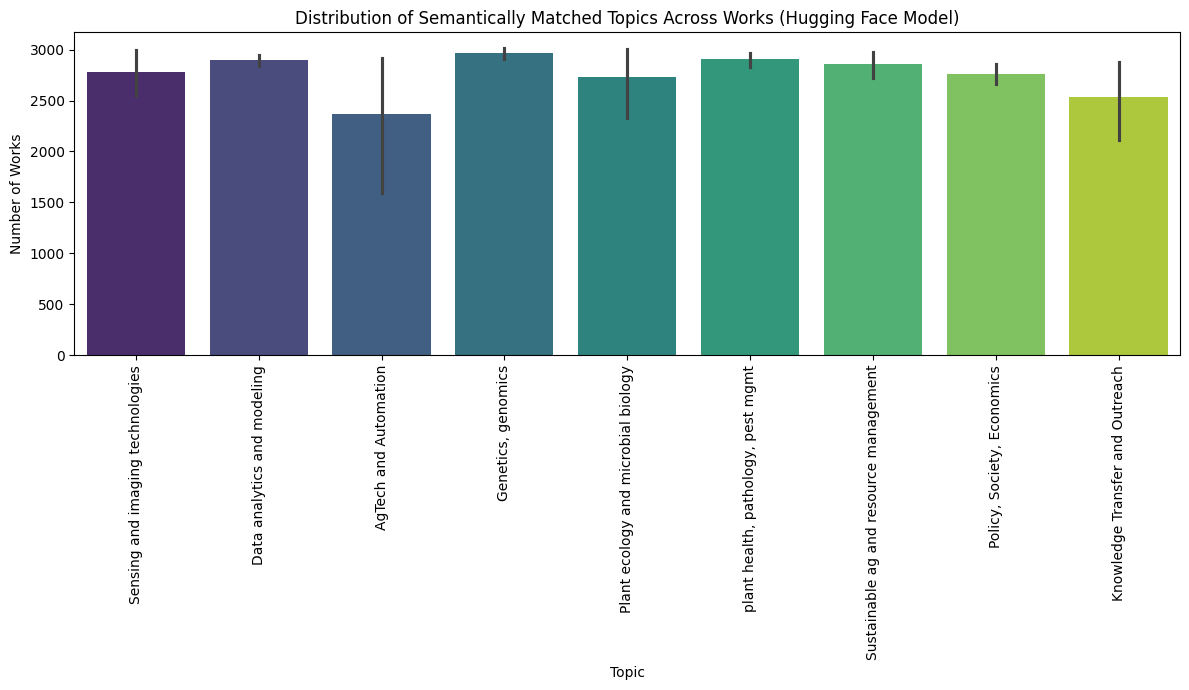

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

works = pd.read_csv("publications_with_newBuckets_labels0.75NEW!.csv")
buckets = pd.read_csv("newModel-Sept 2025.csv")

semantic_topic_counts_hf = defaultdict(int)

# Iterate through the 'semantically_matched_topics_hf_0_75' column
for topics_list in works['semantically_matched_topics(title+abstract)_hf_0_75']:
    # Convert string to list if needed
    if isinstance(topics_list, str):
        try:
            topics_list = ast.literal_eval(topics_list)
        except:
            topics_list = [topics_list]

    if isinstance(topics_list, list):
        for topic_id in topics_list:
            semantic_topic_counts_hf[topic_id] += 1
    elif topics_list is not None:
        semantic_topic_counts_hf[topics_list] += 1

print("\nNumber of works per semantically matched topic ID (Hugging Face model):")
sorted_semantic_topic_counts_hf = dict(sorted(semantic_topic_counts_hf.items()))
for topic_id, count in sorted_semantic_topic_counts_hf.items():
    print(f"Topic ID {topic_id}: {count} works")

semantic_topic_counts_df_hf = pd.DataFrame.from_dict(sorted_semantic_topic_counts_hf, orient='index', columns=['count']).reset_index()
semantic_topic_counts_df_hf = semantic_topic_counts_df_hf.rename(columns={'index': 'topic_id'})

topic_id_to_name = buckets.set_index('Topic ID')['Topics'].to_dict()
semantic_topic_counts_df_hf['topic'] = semantic_topic_counts_df_hf['topic_id'].map(topic_id_to_name)

# Visualize as a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(data=semantic_topic_counts_df_hf, x='topic', y='count', palette='viridis')

plt.title('Distribution of Semantically Matched Topics Across Works (Hugging Face Model)')
plt.xlabel('Topic')
plt.ylabel('Number of Works')
plt.xticks(rotation=90) # Rotate labels for readability
plt.tight_layout() # Adjust layout
plt.show()


Number of works per semantically matched topic ID (Hugging Face model):
Topic ID 0: 2218 works
Topic ID 1: 2027 works
Topic ID 2: 1187 works
Topic ID 3: 530 works
Topic ID 4: 1849 works
Topic ID 5: 2435 works
Topic ID 6: 1406 works
Topic ID 7: 1576 works
Topic ID 8: 1455 works
Topic ID 9: 1923 works
Topic ID 10: 1302 works
Topic ID 11: 1131 works
Topic ID 12: 1583 works
Topic ID 13: 1415 works
Topic ID 14: 2225 works
Topic ID 15: 40 works
Topic ID 16: 1187 works
Topic ID 17: 1935 works
Topic ID 18: 2017 works
Topic ID 19: 336 works
Topic ID 20: 1295 works
Topic ID 21: 2285 works
Topic ID 22: 2412 works
Topic ID 23: 2062 works
Topic ID 24: 2065 works
Topic ID 25: 1787 works
Topic ID 26: 1860 works
Topic ID 27: 2388 works
Topic ID 28: 2402 works
Topic ID 29: 2109 works
Topic ID 30: 2400 works
Topic ID 31: 430 works
Topic ID 32: 1600 works
Topic ID 33: 1351 works
Topic ID 34: 2098 works
Topic ID 35: 2142 works
Topic ID 36: 2026 works
Topic ID 37: 2013 works
Topic ID 38: 1880 works
Topic 

/tmp/ipython-input-2772586187.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=semantic_topic_counts_df_hf, x='topic', y='count', palette='viridis')


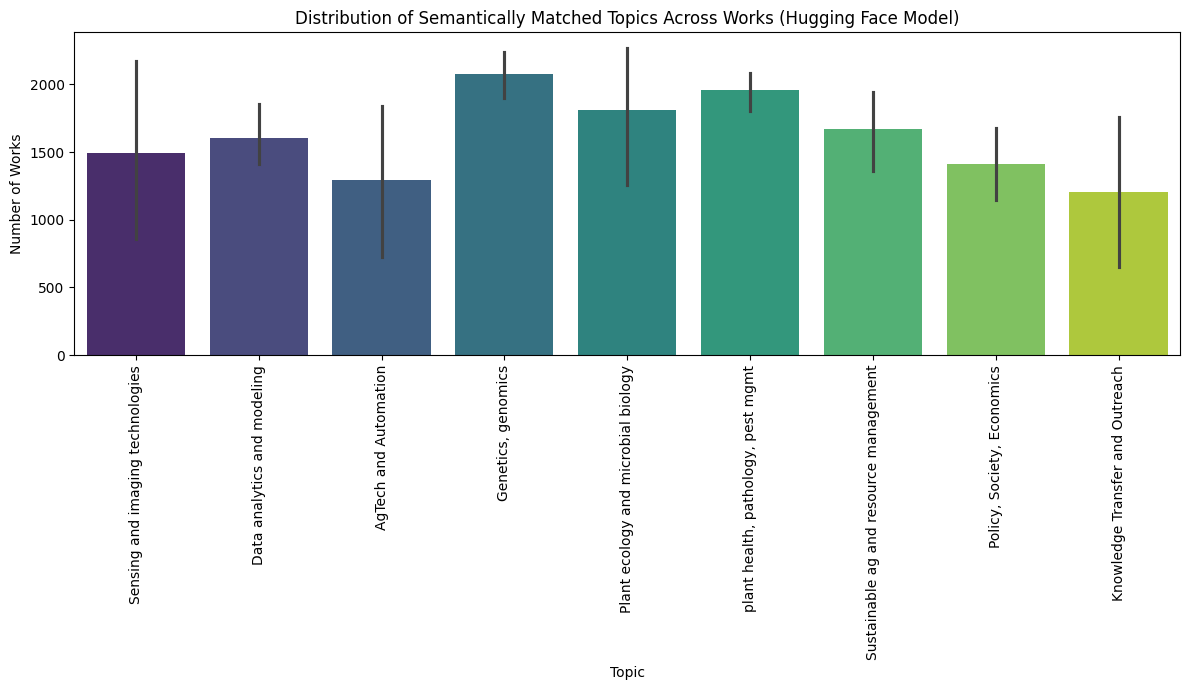

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

works = pd.read_csv("publications_with_newBuckets_labels0.80NEW!.csv")
buckets = pd.read_csv("newModel-Sept 2025.csv")

semantic_topic_counts_hf = defaultdict(int)

# Iterate through the 'semantically_matched_topics_hf_0_8' column
for topics_list in works['semantically_matched_topics(title+abstract)_hf_0_80']:
    # Convert string to list if needed
    if isinstance(topics_list, str):
        try:
            topics_list = ast.literal_eval(topics_list)
        except:
            topics_list = [topics_list]

    if isinstance(topics_list, list):
        for topic_id in topics_list:
            semantic_topic_counts_hf[topic_id] += 1
    elif topics_list is not None:
        semantic_topic_counts_hf[topics_list] += 1

print("\nNumber of works per semantically matched topic ID (Hugging Face model):")
sorted_semantic_topic_counts_hf = dict(sorted(semantic_topic_counts_hf.items()))
for topic_id, count in sorted_semantic_topic_counts_hf.items():
    print(f"Topic ID {topic_id}: {count} works")

semantic_topic_counts_df_hf = pd.DataFrame.from_dict(sorted_semantic_topic_counts_hf, orient='index', columns=['count']).reset_index()
semantic_topic_counts_df_hf = semantic_topic_counts_df_hf.rename(columns={'index': 'topic_id'})

topic_id_to_name = buckets.set_index('Topic ID')['Topics'].to_dict()
semantic_topic_counts_df_hf['topic'] = semantic_topic_counts_df_hf['topic_id'].map(topic_id_to_name)

# Visualize as a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(data=semantic_topic_counts_df_hf, x='topic', y='count', palette='viridis')

plt.title('Distribution of Semantically Matched Topics Across Works (Hugging Face Model)')
plt.xlabel('Topic')
plt.ylabel('Number of Works')
plt.xticks(rotation=90) # Rotate labels for readability
plt.tight_layout() # Adjust layout
plt.show()

## Topic and Keyword Distribution Graph

/tmp/ipython-input-251436941.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_semantic_keywords_per_topic = semantic_topic_keyword_distribution.groupby('topic_id').apply(
/tmp/ipython-input-251436941.py:127: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


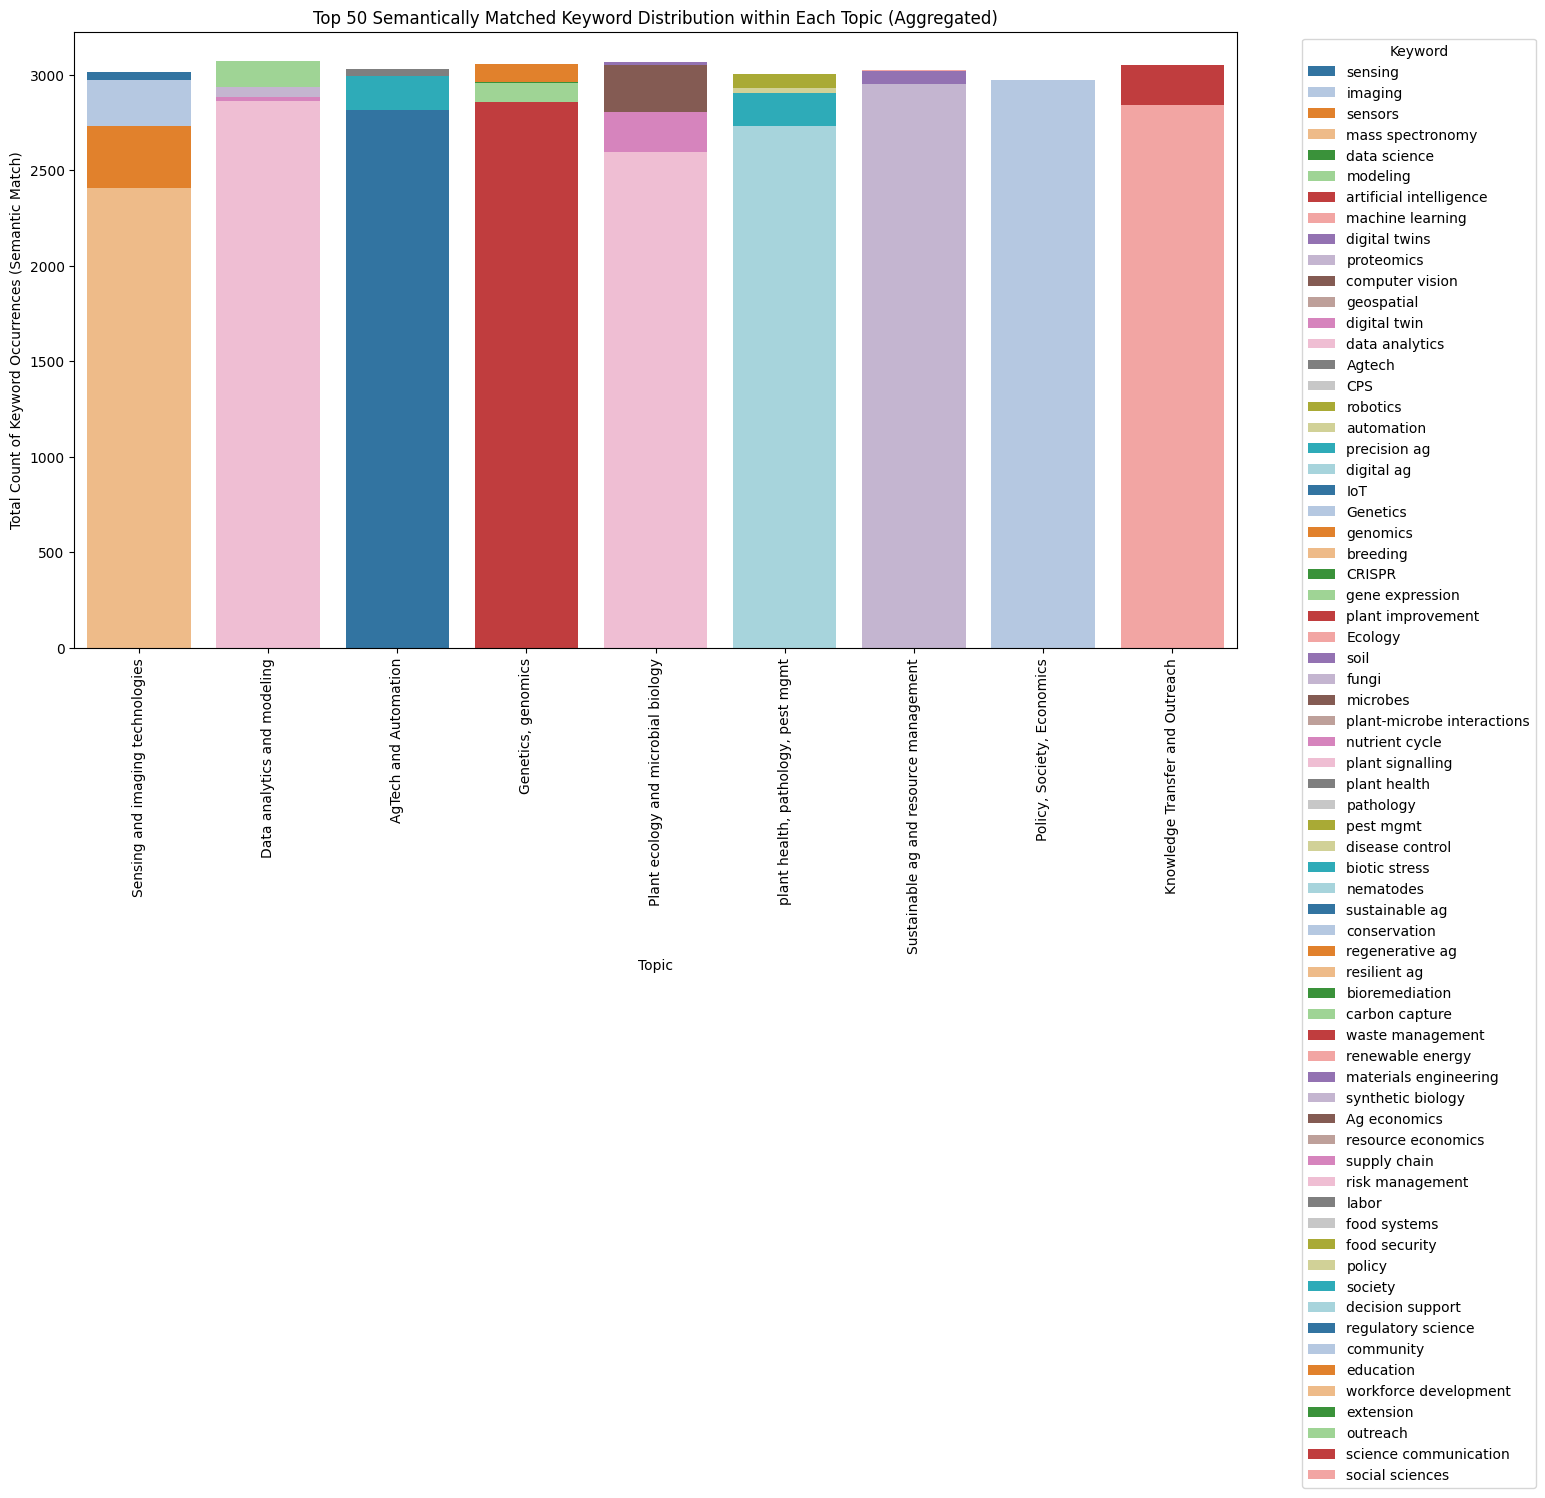

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import ast

# establishing a file since we are dealing with two different threshold
works_path = "publications_with_newBuckets_labels0.75NEW!.csv"
buckets_path = "newModel-Sept 2025.csv"

works = pd.read_csv(works_path)
buckets = pd.read_csv(buckets_path)

# Normalize column names (strip + lowercase for consistency)
works.columns = works.columns.str.strip().str.lower()
buckets.columns = buckets.columns.str.strip().str.lower()

# parse list-like cells safely since white space was becoming and issue along with the
# word of "topic_id"
def safe_parse_list(cell):
    if pd.isna(cell):
        return []
    cell = str(cell).strip()
    if not cell:
        return []
    try:
        # Case: stored as "[1, 2, 3]"
        parsed = ast.literal_eval(cell)
        if isinstance(parsed, list):
            return parsed
        return [parsed]
    except:
        # Case: stored as "1, 2, 3"
        return [c.strip() for c in cell.split(",") if c.strip()]

# Build keyword-to-topic map
# this funtion:
# 1)Splits subtopics by commas.
# 2)Lowercases everything (more consistent matching).
# 3)Doesn’t keep a separate keyword_list.
def build_keyword_to_topic_map(buckets_df):
    keyword_to_topic_map = {}
    for _, row in buckets_df.iterrows():
        topic_id = row['topic id']
        subtopics = str(row['subtopics']).split(",")  # split multiple subtopics
        for sub in subtopics:
            kw = sub.strip().lower()
            if kw:
                if kw not in keyword_to_topic_map:
                    keyword_to_topic_map[kw] = set()
                keyword_to_topic_map[kw].add(topic_id)
    return keyword_to_topic_map

keyword_to_topic_map = build_keyword_to_topic_map(buckets)
topic_id_to_name = buckets.set_index('topic id')['topics'].to_dict()

# Draw a stacked bar chart for keywords within each semantically matched topic
# Prepare data for visualization similar to the exact match approach, but using the semantic results
plot_data_semantic = []

for _, row in works.iterrows():
    work_title = row.get('title')
    semantically_matched_topics = safe_parse_list(row.get('semantically_matched_topics(title+abstract)_hf_0_75'))
    semantically_matched_keywords = safe_parse_list(row.get('semantically_matched_keywords(title+abstract)_hf_0_75'))

    work_semantic_topic_keyword_associations = defaultdict(list)

    for original_kw in semantically_matched_keywords:
        associated_topics = keyword_to_topic_map.get(original_kw.lower(), set())
        relevant_topics_for_this_kw = associated_topics.intersection(set(semantically_matched_topics))

        for topic_id in relevant_topics_for_this_kw:
            work_semantic_topic_keyword_associations[topic_id].append(original_kw)

    for topic_id, original_kws_list in work_semantic_topic_keyword_associations.items():
        keyword_counts = defaultdict(int)
        for kw in original_kws_list:
            keyword_counts[kw.strip()] += 1
        for keyword, count in keyword_counts.items():
            plot_data_semantic.append({
                'topic_id': topic_id,
                'keyword': keyword,
                'count': count,
                'work_title': work_title
            })

plot_df_semantic = pd.DataFrame(plot_data_semantic)

# Aggregate across works
semantic_topic_keyword_distribution = plot_df_semantic.groupby(['topic_id', 'keyword']).agg(
    total_count=('count', 'sum')
).reset_index()

######
# Get the actual topic names
# Ensure topic_id_to_name dictionary is available
if 'topic_id_to_name' not in locals():
    topic_id_to_name = buckets.set_index('topic_id')['topic'].to_dict()

semantic_topic_keyword_distribution['topic'] = semantic_topic_keyword_distribution['topic_id'].map(topic_id_to_name)
######
# Select top N keywords per topic
N = 50
top_semantic_keywords_per_topic = semantic_topic_keyword_distribution.groupby('topic_id').apply(
    lambda x: x.nlargest(N, 'total_count')
).reset_index(drop=True)

# Plot semantic match distribution
plt.figure(figsize=(15, 8))
num_unique_keywords_sem = len(top_semantic_keywords_per_topic['keyword'].unique())
palette_sem = sns.color_palette("tab20", num_unique_keywords_sem)

sns.barplot(
    data=top_semantic_keywords_per_topic,
    x='topic',
    y='total_count',
    hue='keyword',
    dodge=False,
    palette=palette_sem
)

plt.title(f'Top {N} Semantically Matched Keyword Distribution within Each Topic (Aggregated)')
plt.xlabel('Topic')
plt.ylabel('Total Count of Keyword Occurrences (Semantic Match)')
plt.xticks(rotation=90)
plt.legend(title='Keyword', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipython-input-4211913934.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_semantic_keywords_per_topic = semantic_topic_keyword_distribution.groupby('topic_id').apply(
/tmp/ipython-input-4211913934.py:120: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


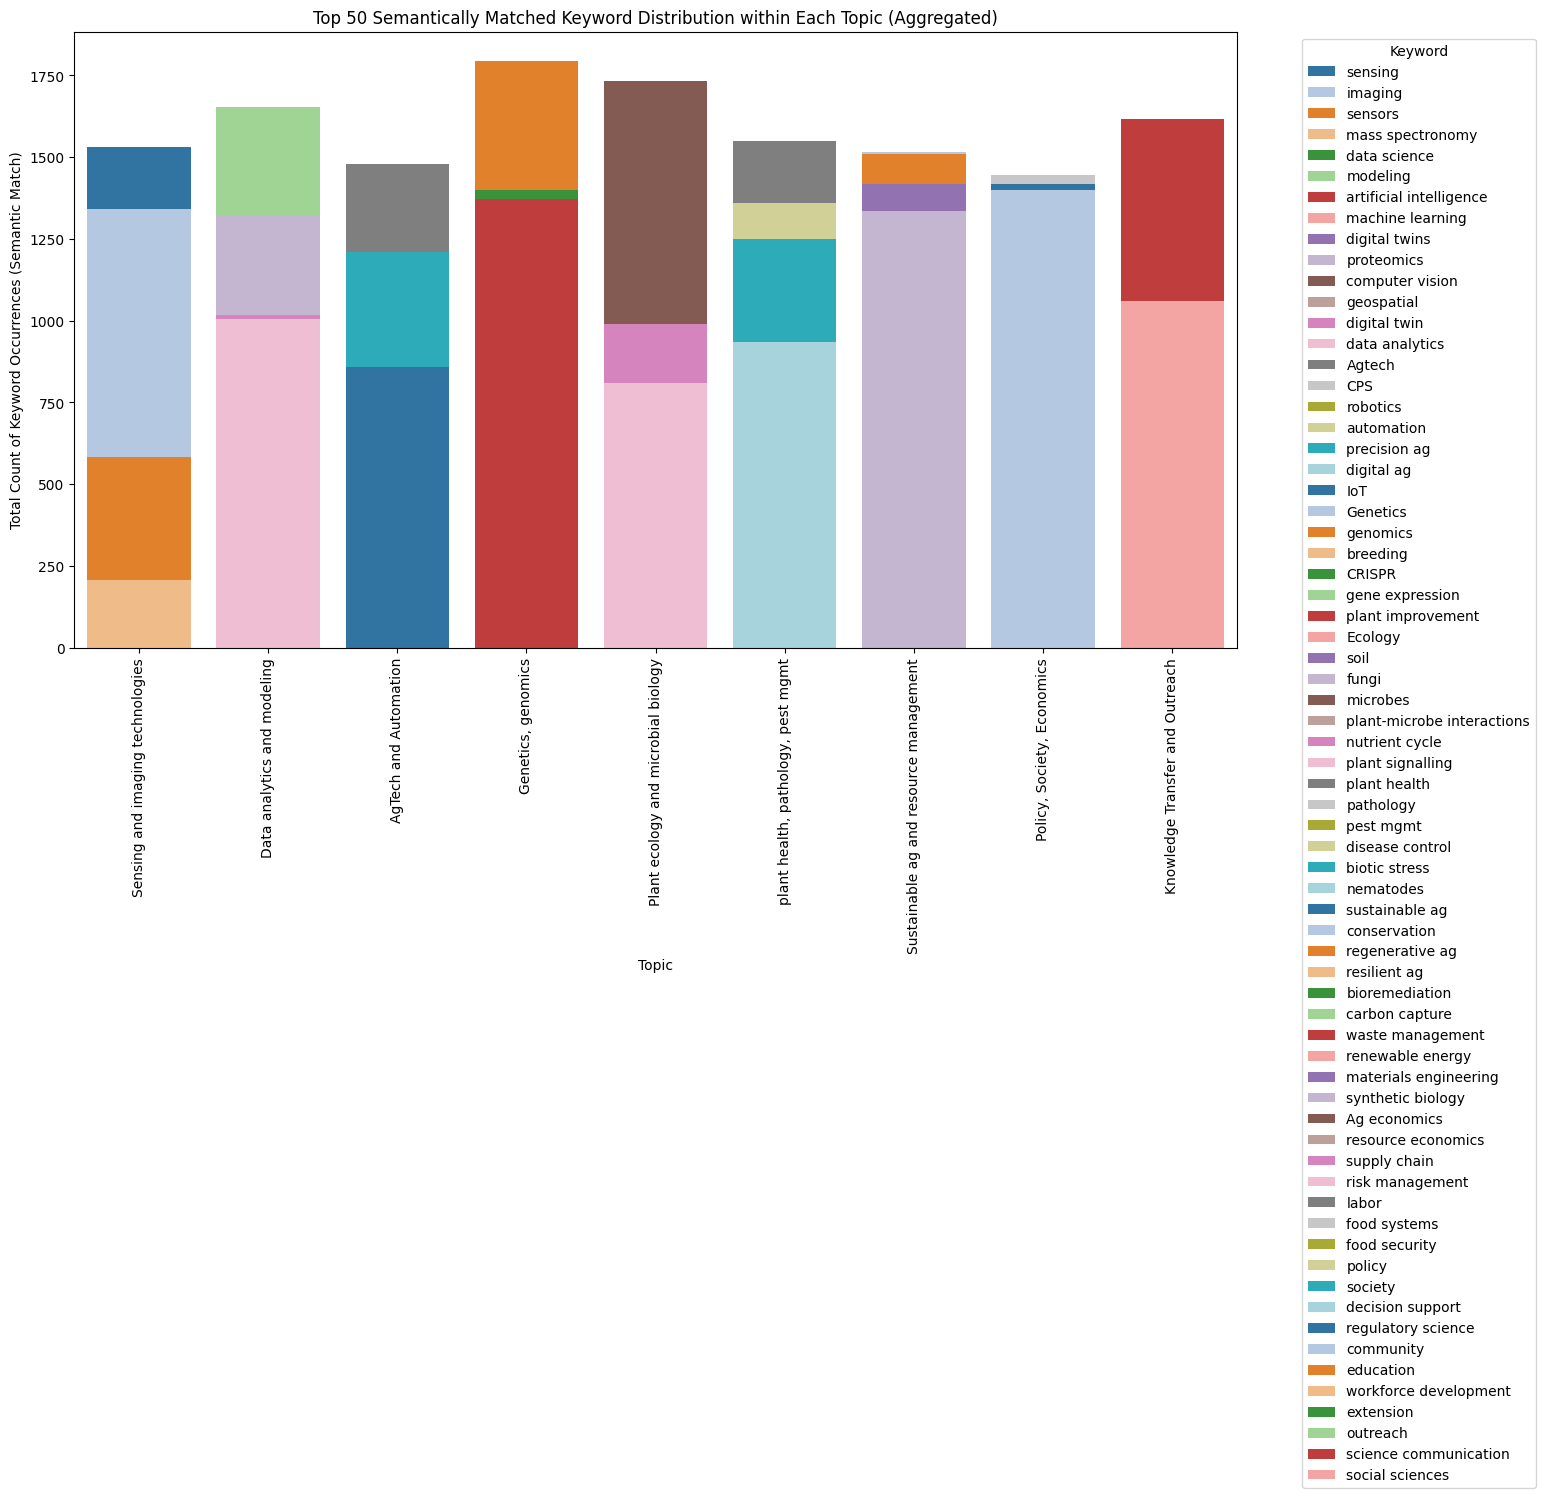

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import ast

works_path = "publications_with_newBuckets_labels0.80UPDATED.csv"
buckets_path = "newModel-Sept 2025.csv"

works = pd.read_csv(works_path)
buckets = pd.read_csv(buckets_path)

# Normalize column names (strip + lowercase for consistency)
works.columns = works.columns.str.strip().str.lower()
buckets.columns = buckets.columns.str.strip().str.lower()

# parse list-like cells safely since white space was becoming and issue along with the
# word of "topic_id"
def safe_parse_list(cell):
    if pd.isna(cell):
        return []
    cell = str(cell).strip()
    if not cell:
        return []
    try:
        # Case: stored as "[1, 2, 3]"
        parsed = ast.literal_eval(cell)
        if isinstance(parsed, list):
            return parsed
        return [parsed]
    except:
        # Case: stored as "1, 2, 3"
        return [c.strip() for c in cell.split(",") if c.strip()]

# Build keyword-to-topic map
# this funtion:
# 1)Splits subtopics by commas.
# 2)Lowercases everything (more consistent matching).
# 3)Doesn’t keep a separate keyword_list.
def build_keyword_to_topic_map(buckets_df):
    keyword_to_topic_map = {}
    for _, row in buckets_df.iterrows():
        topic_id = row['topic id']
        subtopics = str(row['subtopics']).split(",")  # split multiple subtopics
        for sub in subtopics:
            kw = sub.strip().lower()
            if kw:
                if kw not in keyword_to_topic_map:
                    keyword_to_topic_map[kw] = set()
                keyword_to_topic_map[kw].add(topic_id)
    return keyword_to_topic_map

keyword_to_topic_map = build_keyword_to_topic_map(buckets)
topic_id_to_name = buckets.set_index('topic id')['topics'].to_dict()

# Draw a stacked bar chart for keywords within each semantically matched topic
# Prepare data for visualization similar to the exact match approach, but using the semantic results
plot_data_semantic = []

for _, row in works.iterrows():
    work_title = row.get('title')
    semantically_matched_topics = safe_parse_list(row.get('semantically_matched_topics(title+abstract)_hf_0_80'))
    semantically_matched_keywords = safe_parse_list(row.get('semantically_matched_keywords(title+abstract)_hf_0_80'))

    work_semantic_topic_keyword_associations = defaultdict(list)

    for original_kw in semantically_matched_keywords:
        associated_topics = keyword_to_topic_map.get(original_kw.lower(), set())
        relevant_topics_for_this_kw = associated_topics.intersection(set(semantically_matched_topics))

        for topic_id in relevant_topics_for_this_kw:
            work_semantic_topic_keyword_associations[topic_id].append(original_kw)

    for topic_id, original_kws_list in work_semantic_topic_keyword_associations.items():
        keyword_counts = defaultdict(int)
        for kw in original_kws_list:
            keyword_counts[kw.strip()] += 1
        for keyword, count in keyword_counts.items():
            plot_data_semantic.append({
                'topic_id': topic_id,
                'keyword': keyword,
                'count': count,
                'work_title': work_title
            })

plot_df_semantic = pd.DataFrame(plot_data_semantic)

# Aggregate across works
semantic_topic_keyword_distribution = plot_df_semantic.groupby(['topic_id', 'keyword']).agg(
    total_count=('count', 'sum')
).reset_index()

semantic_topic_keyword_distribution['topic'] = semantic_topic_keyword_distribution['topic_id'].map(topic_id_to_name)

# Select top N keywords per topic
N = 50
top_semantic_keywords_per_topic = semantic_topic_keyword_distribution.groupby('topic_id').apply(
    lambda x: x.nlargest(N, 'total_count')
).reset_index(drop=True)

# Plot semantic match distribution
plt.figure(figsize=(15, 8))
num_unique_keywords_sem = len(top_semantic_keywords_per_topic['keyword'].unique())
palette_sem = sns.color_palette("tab20", num_unique_keywords_sem)

sns.barplot(
    data=top_semantic_keywords_per_topic,
    x='topic',
    y='total_count',
    hue='keyword',
    dodge=False,
    palette=palette_sem
)

plt.title(f'Top {N} Semantically Matched Keyword Distribution within Each Topic (Aggregated)')
plt.xlabel('Topic')
plt.ylabel('Total Count of Keyword Occurrences (Semantic Match)')
plt.xticks(rotation=90)
plt.legend(title='Keyword', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
!pip install plotly

In [ ]:
import pandas as pd
import plotly.express as px

# Your data
data = {
    "Topic": [
        "AgTech and Automation",
        "Data analytics and modeling",
        "Genetics, genomics",
        "Knowledge Transfer and Outreach",
        "Plant ecology and microbial biology",
        "Policy, Society, Economics",
        "Sensing and imaging technologies",
        "Sustainable ag and resource management",
        "Plant health, pathology, pest mgmt"
    ],
    "Count": [21753, 40189, 36870, 19046, 35305, 46744, 13909, 45868, 32741]
}

df = pd.DataFrame(data)

# Define custom pastel colors for each topic
pastel_colors = [
    "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9",
    "#BAE1FF", "#D7BAFF", "#FFBAF2", "#BAFFD9", "#FFD8BA"
]

# Create treemap
fig = px.treemap(
    df,
    path=['Topic'],
    values='Count',
    color='Topic',                 # Color by topic
    color_discrete_sequence=pastel_colors  # Use custom pastel colors
)

# Remove title and grey background
fig.update_layout(
    title_text=None,
    paper_bgcolor='white',
    plot_bgcolor='white'
)

# Make text labels bigger for poster readability
fig.update_traces(textfont_size=16)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Your data
data = {
    "Topic": [
        "AgTech and Automation",
        "Data analytics and modeling",
        "Genetics, genomics",
        "Knowledge Transfer and Outreach",
        "Plant ecology and microbial biology",
        "Policy, Society, Economics",
        "Sensing and imaging technologies",
        "Sustainable ag and resource management",
        "Plant health, pathology, pest mgmt"
    ],
    "Count": [21753, 40189, 36870, 19046, 35305, 46744, 13909, 45868, 32741]
}

df = pd.DataFrame(data)

# Define custom pastel colors for each topic
pastel_colors = [
    "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9",
    "#BAE1FF", "#D7BAFF", "#FFBAF2", "#BAFFD9", "#FFD8BA"
]

# Create treemap (no labels)
fig = px.treemap(
    df,
    path=['Topic'],
    values='Count',
    color='Topic',
    color_discrete_sequence=pastel_colors
)

# Remove all text labels and title
fig.update_traces(
    textinfo='none'  # hides all text inside boxes
)

# Clean background
fig.update_layout(
    title_text=None,
    paper_bgcolor='white',
    plot_bgcolor='white',
    margin=dict(t=0, l=0, r=0, b=0)
)

fig.show()


# Adjusting TreeMap Box Sizing for Paper Count Rather Than Collab Count

In [2]:
import pandas as pd
import json

PUBS_CSV = "publications_with_newBuckets_labels0.80Named.csv"
AUTHORS_CSV = "authors_topic_subtopic5NoDup(reran1)2.csv"
OUTPUT_JSON = "jsonRETTL3.json"

# 1. Map Subtopics to Topics and Authors (from your authors CSV)
authors_df = pd.read_csv(AUTHORS_CSV).fillna("-")
# Create a lookup for which Topic a Subtopic belongs to
sub_to_topic = dict(zip(authors_df['subtopic'], authors_df['topic']))
# Create a lookup for authors in each subtopic
sub_to_authors = authors_df.groupby('subtopic')['author_fullname'].apply(list).to_dict()

# 2. Process the Publications
pubs_df = pd.read_csv(PUBS_CSV)
hierarchy = {}

for _, row in pubs_df.iterrows():
    title = row['title']
    # Extract the subtopics list
    raw_subs = row['semantically_matched_keywords(Title+abstract)_hf_0_80']
    clean_subs = str(raw_subs).replace('[', '').replace(']', '').replace("'", "")
    subtopics = [s.strip() for s in clean_subs.split(',') if s.strip()]
    
    for sub in subtopics:
        topic = sub_to_topic.get(sub, "Other")
        if topic not in hierarchy:
            hierarchy[topic] = {}
        if sub not in hierarchy[topic]:
            hierarchy[topic][sub] = []
        
        # Add the paper as a leaf
        hierarchy[topic][sub].append({"name": title, "value": 1})

# 3. Format for D3
json_output = {"name": " ", "children": []}
for topic, subs in hierarchy.items():
    topic_node = {"name": topic, "children": []}
    for sub, papers in subs.items():
        # Attach the author list as metadata to the subtopic for the popup
        sub_authors = list(set(sub_to_authors.get(sub, [])))
        topic_node["children"].append({
            "name": sub,
            "children": papers, # Papers are the children!
            "authorList": sub_authors,
            "collabCount": len(sub_to_authors.get(sub, []))
        })
    json_output["children"].append(topic_node)

with open(OUTPUT_JSON, "w") as f:
    json.dump(json_output, f, indent=1)